In [1]:
%matplotlib inline 

import math
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import model
import model_utils
import preprocessing_utils

#to be put under model.py when I refactor
from tqdm.notebook import tqdm

In [2]:
torch.manual_seed(1234)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 500
batch_size = 12
lr = 0.01
patience = 10

num_timesteps_input = 7 # Default is 30 minutes
num_timesteps_output = 4 # Default is 10 minutes

In [4]:
raw_trunc_dir = "./data/raw/trunc/"
process_dir = "./data/processed/"

# overwrite = False means that the processing function will only run if the process data files do not exist
# overwrite = True => functions will run regardless
preprocessing_utils.processed(raw_trunc_dir, process_dir, overwrite=False)
A, X, metadata, means, stds = preprocessing_utils.load(process_dir)

split_line1 = int(X.shape[2] * 0.6)
split_line2 = int(X.shape[2] * 0.8)

train_original_data = X[:, :, :split_line1]
val_original_data = X[:, :, split_line1:split_line2]
test_original_data = X[:, :, split_line2:]

training_input, training_target = preprocessing_utils.generate_dataset(train_original_data,
                                                   num_timesteps_input=num_timesteps_input,
                                                   num_timesteps_output=num_timesteps_output)
val_input, val_target = preprocessing_utils.generate_dataset(val_original_data,
                                         num_timesteps_input=num_timesteps_input,
                                         num_timesteps_output=num_timesteps_output)
test_input, test_target = preprocessing_utils.generate_dataset(test_original_data,
                                           num_timesteps_input=num_timesteps_input,
                                           num_timesteps_output=num_timesteps_output)

# input shape (num_samples ,num_vertices, num_timesteps_window, num_features)
# output shape (num_samples ,num_vertices, num_timesteps_window)
adj_mat = preprocessing_utils.get_normalized_adj(A)
adj_mat = torch.from_numpy(adj_mat).to(device)

In [5]:
def train(x_input, x_target, batch_size):
    """
    Train function per epoch
    """
    
    stgcn.train()
    
    num_samples = x_input.shape[0]
    shuffled_order = torch.randperm(num_samples)
    
    training_loss = []
    
    for i in range(math.ceil(num_samples / batch_size)):

        optimizer.zero_grad()
        
        start = i * batch_size
        batch = shuffled_order[start:start+batch_size]
        
        #Drop left-overs
        if len(batch) % batch_size != 0:
            continue
        
        x_batch = x_input[batch].to(device = device)
        y_batch = x_target[batch].to(device = device)
        
        out = stgcn(adj_mat, x_batch)
        loss = loss_criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        
        training_loss.append(loss.detach().cpu().numpy())
        
    return sum(training_loss) / len(training_loss)

In [6]:
stgcn = model.Stgcn_Model(nodes_num = adj_mat.shape[0], features_num = training_input.shape[3],
                    input_timesteps = num_timesteps_input, num_output = num_timesteps_output).to(device = device)

optimizer = torch.optim.Adam(stgcn.parameters(), lr = lr)
loss_criterion = nn.MSELoss()

best_loss = float("inf")
early_stop = 0
best_weights = None

training_loss = []
validation_loss = []

pbar = tqdm(range(epochs))
for epoch in pbar:
    
    pbar.set_description(f"Epoch {epoch}")
    
    loss = train(training_input, training_target, batch_size)
    training_loss.append(loss)

    with torch.no_grad():
        val_loss = model_utils.validate(stgcn, loss_criterion, val_input, val_target, adj_mat, batch_size, device)
        validation_loss.append(val_loss.item())
    
    pbar.set_postfix(training_loss=loss, validation_loss=val_loss.item())
        
    if val_loss < best_loss:
        early_stop = 0
        best_loss = val_loss
        best_weights = copy.deepcopy(stgcn.state_dict())
    else:
        early_stop += 1
                
    if early_stop == patience:
        stgcn.load_state_dict(best_weights)
        break


#For Model saving purposes
stgcn.lr = lr 
stgcn.nodes_num = adj_mat.shape[0]
stgcn.features_num = training_input.shape[3]
stgcn.input_timesteps = num_timesteps_input
stgcn.num_output = num_timesteps_output

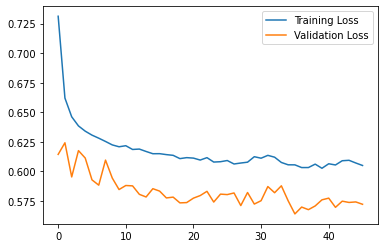

In [7]:
plt.plot(training_loss, label = 'Training Loss')
plt.plot(validation_loss, label = 'Validation Loss')
plt.legend()
plt.show()

In [8]:
torch.manual_seed(1234)

with torch.no_grad():
    test_loss = model_utils.validate(stgcn, loss_criterion, test_input, test_target, adj_mat, batch_size, device)
    print(test_loss)

tensor(0.5088)


In [9]:
results = model_utils.predict(stgcn, test_input, batch_size, adj_mat)

In [10]:
#print(preprocessing_utils.denormalize(results, stds[0], means[0]))

[[[tensor([[[3.2581, 3.3857, 3.1564, 3.0944],
         [3.2539, 3.4401, 3.4288, 3.5406],
         [4.2219, 4.3346, 4.3395, 4.0519],
         ...,
         [4.5521, 4.7069, 4.8391, 4.6491],
         [3.6170, 3.5943, 3.4478, 3.5607],
         [4.8077, 4.6637, 4.6806, 4.7120]],

        [[3.0923, 3.3186, 3.1351, 2.9673],
         [3.1860, 3.3671, 3.3182, 3.5183],
         [4.1638, 4.2204, 4.2865, 4.0631],
         ...,
         [4.5047, 4.5670, 4.7568, 4.6432],
         [3.5995, 3.7174, 3.5027, 3.5551],
         [4.7203, 4.7077, 4.7736, 4.8714]],

        [[3.1297, 3.4499, 3.2329, 3.0609],
         [3.3013, 3.4428, 3.4502, 3.5413],
         [4.1668, 4.2241, 4.2737, 4.0743],
         ...,
         [4.3890, 4.5692, 4.7194, 4.6477],
         [3.6026, 3.6652, 3.4391, 3.5702],
         [4.7120, 4.7312, 4.7966, 4.7650]],

        ...,

        [[3.1139, 3.4621, 3.0264, 3.0758],
         [3.1747, 3.5300, 3.5454, 3.5806],
         [4.1650, 4.2338, 4.2959, 4.0706],
         ...,
         [4.3362, 

In [11]:
#print(preprocessing_utils.denormalize(test_target, stds[0], means[0]))

tensor([[[3., 3., 3., 3.],
         [3., 3., 3., 3.],
         [4., 4., 4., 4.],
         ...,
         [5., 5., 4., 4.],
         [3., 3., 3., 3.],
         [5., 5., 4., 4.]],

        [[3., 3., 3., 3.],
         [3., 3., 3., 3.],
         [4., 4., 4., 5.],
         ...,
         [5., 4., 4., 4.],
         [3., 3., 3., 3.],
         [5., 4., 4., 4.]],

        [[3., 3., 3., 3.],
         [3., 3., 3., 3.],
         [4., 4., 5., 5.],
         ...,
         [4., 4., 4., 4.],
         [3., 3., 3., 3.],
         [4., 4., 4., 4.]],

        ...,

        [[4., 4., 4., 3.],
         [4., 4., 4., 4.],
         [5., 5., 5., 5.],
         ...,
         [5., 5., 5., 5.],
         [4., 4., 4., 4.],
         [5., 6., 6., 5.]],

        [[4., 4., 3., 4.],
         [4., 4., 4., 4.],
         [5., 5., 5., 5.],
         ...,
         [5., 5., 5., 4.],
         [4., 4., 4., 4.],
         [6., 6., 5., 4.]],

        [[4., 3., 4., 4.],
         [4., 4., 4., 4.],
         [5., 5., 5., 5.],
         ...,
 

In [12]:
model_utils.save_model(stgcn,optimizer)

Model has been saved to path : ./saved_models/20210423/23_12_50


In [13]:
loaded_model, loaded_optimizer = model_utils.load_model(path=None)

Loading model in path : ./saved_models/20210423/23_12_50


In [14]:
torch.manual_seed(1234)

#Testing loaded model
loaded_model.to(device)

with torch.no_grad():
    test_loss = model_utils.validate(loaded_model, loss_criterion, test_input, test_target, adj_mat, batch_size, device)
    print(test_loss)

tensor(0.5088)
